In [1]:
from dataset import MolerDataset, MolerData
from utils import pprint_pyg_obj
from torch_geometric.loader import DataLoader

dataset = MolerDataset(
    root = '/data/ongh0068', 
    raw_moler_trace_dataset_parent_folder = '/data/ongh0068/l1000/trace_playground',
    output_pyg_trace_dataset_parent_folder = '/data/ongh0068/l1000/pyg_output_playground',
    split = 'train',
)

loader = DataLoader(dataset, batch_size=16, shuffle=False, follow_batch = [
    'correct_edge_choices',
    'correct_edge_types',
    'valid_edge_choices',
    'valid_attachment_point_choices',
    'correct_attachment_point_choice',
    'correct_node_type_choices',
    'original_graph_x',
    'correct_first_node_type_choices'
])

2022-12-24 09:22:07.836098: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
for batch in loader:
    
    break

In [8]:
import torch
from model_utils import get_params
params = get_params()

In [9]:
%load_ext autoreload
%autoreload 2
from model import BaseModel


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
model = BaseModel(params, dataset).eval()

moler_output = model._run_step(batch)

loss = model.compute_loss(moler_output, batch)

loss

tensor(5.1451, dtype=torch.float64, grad_fn=<AddBackward0>)

In [11]:
def decode(
    graph_representations,
    initial_molecules= None,
    mol_ids = None,
    store_generation_traces = False,
    max_num_steps=120,
    beam_size= 1,
    sampling_mode = 'greedy',
)

SyntaxError: invalid syntax (2536383891.py, line 9)

In [13]:
with torch.no_grad():
    input_molecule_representations = model._full_graph_encoder(
        original_graph_node_categorical_features=batch.original_graph_node_categorical_features,
        node_features=batch.original_graph_x.float(),
        edge_index=batch.original_graph_edge_index,
        edge_type=batch.original_graph_edge_type.int(),
        batch_index=batch.original_graph_x_batch,
    )


    partial_graph_representions, node_representations = model._partial_graph_encoder(
        partial_graph_node_categorical_features = batch.partial_node_categorical_features,
        node_features = batch.x,
        edge_index = batch.edge_index.long(), 
        edge_type = batch.edge_type, 
        graph_to_focus_node_map = batch.focus_node,
        candidate_attachment_points = batch.valid_attachment_point_choices,
        batch_index = batch.batch
    )
    # Apply latent sampling strategy
    p, q, latent_representations = model.sample_from_latent_repr(
        input_molecule_representations
    )

In [8]:
latent_representations.shape

torch.Size([16, 512])

# Preprocessing before algorithm

In [14]:
from rdkit import Chem
from molecule_generation.chem.molecule_dataset_utils import BOND_DICT
from molecule_generation.chem.motif_utils import (
    find_motifs_from_vocabulary,
)
uses_motifs = True
initial_molecules = None
mol_ids = None
store_generation_traces = False

graph_representations = latent_representations

if initial_molecules is None:
    initial_molecules = [None] * len(graph_representations)

# Replace `None` in initial_molecules with empty molecules.
initial_molecules = [
    Chem.Mol() if initMol is None else initMol for initMol in initial_molecules
]
if mol_ids is None:
    mol_ids = range(len(graph_representations))

In [15]:
from molecule_generation.utils.moler_decoding_utils import (
    DecoderSamplingMode,
    sample_indices_from_logprobs,
    restrict_to_beam_size_per_mol,
    MoLeRDecoderState,
    MoleculeGenerationAtomChoiceInfo,
    MoleculeGenerationAttachmentPointChoiceInfo,
    MoleculeGenerationEdgeChoiceInfo,
    MoleculeGenerationEdgeCandidateInfo,
)

In [16]:
decoder_states = []


# preprocessing for when a scaffold is given
for graph_repr, init_mol, mol_id in zip(graph_representations, initial_molecules, mol_ids):
    num_free_bond_slots = [0] * len(init_mol.GetAtoms())

    atom_ids_to_remove = []
    atom_ids_to_keep = []

    for atom in init_mol.GetAtoms():
        if atom.GetAtomicNum() == 0:
            # Atomic number 0 means a placeholder atom that signifies an attachment point.
            bonds = atom.GetBonds()

            if len(bonds) > 1:
                scaffold = Chem.MolToSmiles(init_mol)
                raise ValueError(
                    f"Scaffold {scaffold} contains a [*] atom with at least two bonds."
                )

            if not bonds:
                # This is a very odd case: either the scaffold we got is disconnected, or
                # it consists of just a single * atom.
                scaffold = Chem.MolToSmiles(init_mol)
                raise ValueError(f"Scaffold {scaffold} contains a [*] atom with no bonds.")

            [bond] = bonds
            begin_idx = bond.GetBeginAtomIdx()
            end_idx = bond.GetEndAtomIdx()

            neighbour_idx = begin_idx if begin_idx != atom.GetIdx() else end_idx
            num_free_bond_slots[neighbour_idx] += 1

            atom_ids_to_remove.append(atom.GetIdx())
        else:
            atom_ids_to_keep.append(atom.GetIdx())

    if not atom_ids_to_remove:
        # No explicit attachment points, so assume we can connect anywhere.
        num_free_bond_slots = None
    else:
        num_free_bond_slots = [num_free_bond_slots[idx] for idx in atom_ids_to_keep]
        init_mol = Chem.RWMol(init_mol)

        # Remove atoms starting from largest index, so that we don't have to account for
        # indices shifting during removal.
        for atom_idx in reversed(atom_ids_to_remove):
            init_mol.RemoveAtom(atom_idx)

        # Determine how the scaffold atoms will get reordered when we canonicalize it, so we can
        # permute `num_free_bond_slots` appropriately.
        canonical_ordering = compute_canonical_atom_order(init_mol)
        num_free_bond_slots = [num_free_bond_slots[idx] for idx in canonical_ordering]

    # Now canonicalize, which renumbers all the atoms, but we've applied the same
    # renumbering to `num_free_bond_slots` earlier.
    init_mol = Chem.MolFromSmiles(Chem.MolToSmiles(init_mol))

    # Clear aromatic flags in the scaffold, since partial graphs during training never have
    # them set (however we _do_ run `AtomIsAromaticFeatureExtractor`, it just always returns
    # 0 for partial graphs during training).
    # TODO(kmaziarz): Consider fixing this.
    Chem.Kekulize(init_mol, clearAromaticFlags=True)

    init_atom_types = []
    # TODO(kmaziarz): We need to be more careful in how the initial molecule looks like, to
    # make sure that `init_mol`s have correct atom features (e.g. charges).
    for atom in init_mol.GetAtoms():
        init_atom_types.append(get_atom_symbol(atom))
    adjacency_lists = [[] for _ in range(len(BOND_DICT))]
    for bond in init_mol.GetBonds():
        bond_type_idx = BOND_DICT[str(bond.GetBondType())]
        adjacency_lists[bond_type_idx].append(
            (bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())
        )
        adjacency_lists[bond_type_idx].append(
            (bond.GetEndAtomIdx(), bond.GetBeginAtomIdx())
        )

    if uses_motifs:
        init_mol_motifs = find_motifs_from_vocabulary(
            molecule=init_mol, motif_vocabulary=dataset._motif_vocabulary
        )
    else:
        init_mol_motifs = []

    decoder_states.append(
        MoLeRDecoderState(
            molecule_representation=graph_repr,
            molecule_id=mol_id,
            molecule=init_mol,
            atom_types=init_atom_types,
            adjacency_lists=adjacency_lists,
            visited_atoms=[atom.GetIdx() for atom in init_mol.GetAtoms()],
            atoms_to_visit=[],
            focus_atom=None,
            # Pseudo-randomly pick last atom from input:
            prior_focus_atom=len(init_atom_types) - 1,
            generation_steps=[] if store_generation_traces else None,
            motifs=init_mol_motifs,
            num_free_bond_slots=num_free_bond_slots,
        )
    )

decoder_states_empty = []
decoder_states_non_empty = []

for decoder_state in decoder_states:
    if decoder_state.molecule.GetNumAtoms() == 0:
        decoder_states_empty.append(decoder_state)
    else:
        decoder_states_non_empty.append(decoder_state)


# _decoder_pick_first_atom_types


In [17]:
from decoding_utils import sample_indices_from_logprobs
import numpy as np


num_samples = 1
decoder_states = decoder_states_empty
sampling_mode =  'greedy'
index_to_node_type_map=dataset.node_type_index_to_string

with torch.no_grad():
    # We only need the molecule representations.
    molecule_representations = torch.stack(
        [state.molecule_representation for state in decoder_states]
    )

    first_node_type_logits = model.decoder.pick_first_node_type(
        latent_representations=latent_representations
    )  # Shape [G, NT + 1]

    first_atom_type_logprobs = torch.nn.functional.log_softmax(
        first_node_type_logits[:, 1:], dim=-1 # because index 0 corresponds to UNK
    )  # Shape [G, NT]

    first_atom_type_pick_results = []


    # Iterate over each of the rows independently, sampling for each input state:
    for state_first_atom_type_logprobs in first_atom_type_logprobs:
        picked_atom_type_indices = sample_indices_from_logprobs(
            num_samples, sampling_mode, state_first_atom_type_logprobs
        )

        this_state_results = []

        for picked_atom_type_idx in picked_atom_type_indices:
            pick_logprob = state_first_atom_type_logprobs[picked_atom_type_idx]
            picked_atom_type_idx += 1  # Revert the stripping out of the UNK (index 0) type

            this_state_results.append(
                (index_to_node_type_map[picked_atom_type_idx.item()], pick_logprob)
            )

        first_atom_type_pick_results.append(
            (this_state_results, state_first_atom_type_logprobs)
        )


In [18]:
# # def view_mol(,)
# from rdkit.Chem import Draw
# Draw.MolsToGridImage([Chem.MolFromSmiles(first_atom_type_pick_results[i][0][0][0]) for i in range(len(first_atom_type_pick_results))], subImgSize=(250,250))
# Chem.MolFromSmiles(), Chem.MolFromSmiles(first_atom_type_pick_results[1][0][0][0])

In [19]:
first_node_pick_results = first_atom_type_pick_results

In [20]:
# set(atom_type_featuriser.index_to_atom_type_map.values())

_atom_types = set(dataset._atom_type_featuriser.index_to_atom_type_map.values())

In [21]:
def _is_atom_type( node_type):
    if not uses_motifs:
        return True
    else:
        return node_type in _atom_types
    
def _add_atom_or_motif(
    decoder_state,
    node_type,
    logprob,
    choice_info,
):
    # If we are running with motifs, we need to check whether `node_type` is an atom or a motif.
    if _is_atom_type(node_type):
        # print(I {decoder_state.molecule_id} {decoder_state.logprob:12f}: Adding new atom {node_type} - p={logprob:5f}")
        return (
            MoLeRDecoderState.new_with_added_atom(
                decoder_state,
                node_type,
                atom_logprob=logprob,
                atom_choice_info=choice_info,
            ),
            False,
        )
    else:
        # print(I {decoder_state.molecule_id} {decoder_state.logprob:12f}: Adding motif {node_type} - p={logprob:5f}")
        return (
            MoLeRDecoderState.new_with_added_motif(
                decoder_state,
                node_type,
                motif_logprob=logprob,
                atom_choice_info=choice_info,
            ),
            True,
        )

In [22]:

decoder_states = decoder_states_non_empty

for decoder_state, (first_node_type_picks, first_node_type_logprobs) in zip(
    decoder_states_empty, first_node_pick_results
):
    for first_node_type_pick, first_node_type_logprob in first_node_type_picks:
        # Set up generation trace storing variables, populating if needed.
        atom_choice_info = None
        if store_generation_traces:
            atom_choice_info = MoleculeGenerationAtomChoiceInfo(
                node_idx=0,
                true_type_idx=None,
                type_idx_to_prob=np.exp(first_node_type_logprobs),
            )

        new_decoder_state, added_motif = _add_atom_or_motif(
            decoder_state,
            first_node_type_pick,
            logprob=first_node_type_logprob,
            choice_info=atom_choice_info,
        )

        last_atom_id = new_decoder_state.molecule.GetNumAtoms() - 1

        if added_motif:
            # To make all asserts happy, pretend we chose an attachment point.
            new_decoder_state._focus_atom = last_atom_id

        # Mark all initial nodes as visited.
        new_decoder_state = MoLeRDecoderState.new_with_focus_marked_as_visited(
            old_state=new_decoder_state, focus_node_finished_logprob=0.0
        )

        # Set the prior focus atom similarly to the start-from-scaffold case.
        new_decoder_state._prior_focus_atom = last_atom_id

        decoder_states.append(new_decoder_state)

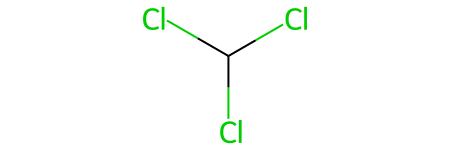

In [67]:
decoder_states[0].molecule

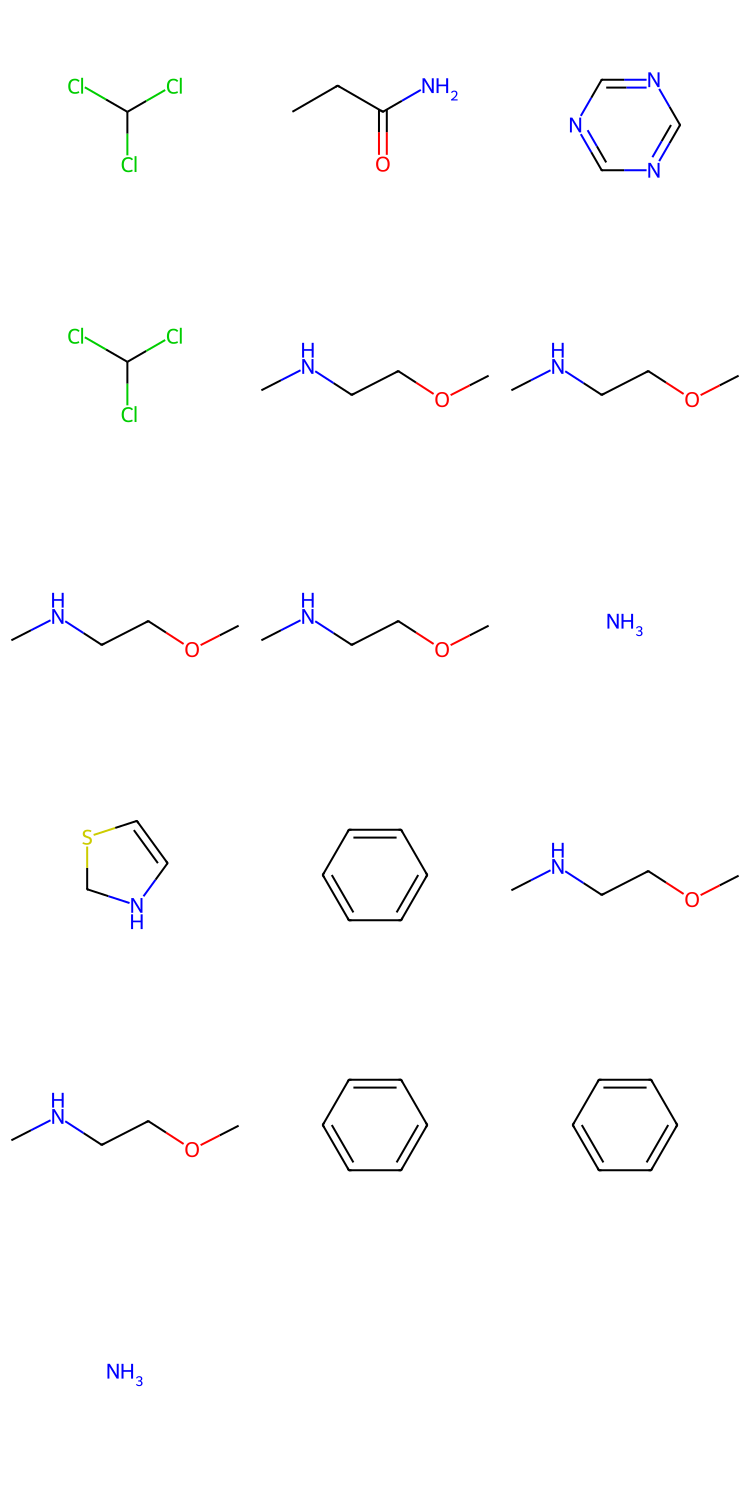

In [68]:


Draw.MolsToGridImage([decoder_states[i].molecule for i in range(len(decoder_states))], subImgSize=(250,250))


In [23]:
from torch_geometric.data import Batch

batch = Batch.from_data_list([dataset[0], dataset[1]], follow_batch = [
    'correct_edge_choices',
    'correct_edge_types',
    'valid_edge_choices',
    'valid_attachment_point_choices',
    'correct_attachment_point_choice',
    'correct_node_type_choices',
    'original_graph_x',
    'correct_first_node_type_choices'
])

In [24]:

atom_featurisers =dataset._metadata['feature_extractors']
motif_vocabulary=dataset._motif_vocabulary


for decoder_state in decoder_states:
    node_features, node_categorical_features = decoder_state.get_node_features(
        atom_featurisers, motif_vocabulary
    )
    mol_num_nodes = node_features.shape[0]

In [86]:
decoder_states[0].prior_focus_atom

3

In [43]:
def _to_tensor_moler(decoder_state_features, ignore = []):
    for k, v in decoder_state_features.items():
        if k in ignore:
            continue
        decoder_state_features[k] = torch.tensor(decoder_state_features[k])
    return decoder_state_features



def batch_decoder_states(
    batch_size,
    atom_featurisers, #=dataset._metadata['feature_extractors'] ,
    motif_vocabulary,#=dataset._motif_vocabulary , 
    uses_categorical_features, #= True,
    decoder_states,#=decoder_states,
#     init_batch_callback=init_atom_choice_batch,
#     add_state_to_batch_callback=add_state_to_atom_choice_batch,
):
    current_batch = []
    for decoder_state in decoder_states:
        node_features, node_categorical_features = decoder_state.get_node_features(
            atom_featurisers, motif_vocabulary
        )
        mol_num_nodes = node_features.shape[0]
        
        decoder_state_features = {
            'latent_representation':decoder_state.molecule_representation, 
            'x': node_features,
            'node_categorical_features': node_categorical_features,
        }
        
        edge_indexes = []
        edge_types = []
        for edge_type_idx, adj_list in enumerate(decoder_state.adjacency_lists):
            if len(adj_list) > 0:
                edge_index = np.array(adj_list, dtype=np.int32).T
                edge_indexes += [edge_index]
                """ 
                edge types: 
                single bond => 0
                double bond => 1
                triple bond => 2
                self loop => 3
                """
                edge_types += [edge_type_idx] * len(adj_list)
#         print(edge_indexes)
        decoder_state_features["edge_index"] = (
            np.concatenate(edge_indexes, 1)
            if len(edge_indexes) > 0
            else np.array(edge_indexes)
        )
        decoder_state_features["edge_type"] = np.array(edge_types)
        
        ### pick_attachment_points
        decoder_state_features['candidate_attachment_points'] = decoder_state.candidate_attachment_points,
        ### pick_attachment_points
        
        
        ### pick_new_nodes
        
        ### pick_new_nodes
        
        
        ### pick_edge
        
        
        ### pick_edge
        
        
        
        
        decoder_state_features = _to_tensor_moler(decoder_state_features, ignore = ['latent_representation'])
#         print(decoder_state_features)
        current_batch += [(MolerData(**decoder_state_features), decoder_state)]
        if len(current_batch) == batch_size:
            tmp = current_batch
            current_batch = []
            yield (Batch.from_data_list([i[0] for i in tmp], follow_batch = [
                'correct_edge_choices',
                'correct_edge_types',
                'valid_edge_choices',
                'valid_attachment_point_choices',
                'correct_attachment_point_choice',
                'correct_node_type_choices',
                'original_graph_x',
                'correct_first_node_type_choices',
                'candidate_attachment_points'
            ]), [i[1] for i in tmp])
    if len(current_batch) > 0:
        yield Batch.from_data_list(current_batch, follow_batch = [
            'correct_edge_choices',
            'correct_edge_types',
            'valid_edge_choices',
            'valid_attachment_point_choices',
            'correct_attachment_point_choice',
            'correct_node_type_choices',
            'original_graph_x',
            'correct_first_node_type_choices',
            'candidate_attachment_points'
        ])
        


In [44]:
dataloader = batch_decoder_states(
    batch_size = 16,
    atom_featurisers =dataset._metadata['feature_extractors'] ,
    motif_vocabulary=dataset._motif_vocabulary , 
    uses_categorical_features = True,
    decoder_states=decoder_states,
)

In [45]:
for batch2 in dataloader:
    print(batch2)
#     break

(MolerDataBatch(x=[104, 32], edge_index=[2, 180], latent_representation=[16, 512], candidate_attachment_points=[57], candidate_attachment_points_batch=[57], candidate_attachment_points_ptr=[17], node_categorical_features=[104], edge_type=[180], batch=[104], ptr=[17]), [<molecule_generation.utils.moler_decoding_utils.MoLeRDecoderState object at 0x7fa78ec3f0d0>, <molecule_generation.utils.moler_decoding_utils.MoLeRDecoderState object at 0x7fa78ec3f610>, <molecule_generation.utils.moler_decoding_utils.MoLeRDecoderState object at 0x7fa78ef62dc0>, <molecule_generation.utils.moler_decoding_utils.MoLeRDecoderState object at 0x7fa78ef62130>, <molecule_generation.utils.moler_decoding_utils.MoLeRDecoderState object at 0x7fa78ef62460>, <molecule_generation.utils.moler_decoding_utils.MoLeRDecoderState object at 0x7fa78ef62790>, <molecule_generation.utils.moler_decoding_utils.MoLeRDecoderState object at 0x7fa78ef62cd0>, <molecule_generation.utils.moler_decoding_utils.MoLeRDecoderState object at 0x7

In [46]:
batch = batch2

In [51]:
initial_focus_atom_idx = batch[0].candidate_attachment_points_ptr[:-1]

In [52]:
batch[0].candidate_attachment_points_batch[initial_focus_atom_idx]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [53]:
initial_focus_atoms = batch[0].candidate_attachment_points[initial_focus_atom_idx]

tensor([ 0,  4, 14, 20, 31, 37, 41, 47, 53, 59, 65, 76, 82, 86, 92, 98])

In [33]:
focus_atoms = np.array(
    [attachment_points[0] for attachment_points in batch[0].candidate_attachment_points]
)

IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

# Design

Instead of the decoder housing all these functions, the lightning module will house it instead. All the functions required for actually decoding the latent vector into a molecule will be in the lightning module because further down the road, when we use diffusion, this additional function has to be accessible outside of the decoder since it is agnostic of the decoder

# TODO

separate out the processing related to picking edges, picking nodes and picking attachment points into different call back functions to reduce time taken for batching

In [76]:
def _pick_attachment_points_for_batch(
    batch,
    decoder_states,
    num_samples=1,
    sampling_mode='greedy',
):
    
    initial_focus_atom_idx = batch.candidate_attachment_points_ptr[:-1]
    
    initial_focus_atoms = batch.candidate_attachment_points[initial_focus_atom_idx]
    
    candidate_attachment_points = batch.candidate_attachment_points
    
    graph_representations, node_representations = model._partial_graph_encoder(
        node_features=batch.x,
        partial_graph_node_categorical_features=batch.node_categorical_features,
        edge_index=batch.edge_index,
        edge_type = batch.edge_type, 
        # Here we choose an arbitrary attachment point as a focus atom; this does not matter
        # since later all candidate attachment points are marked with the in-focus bit.
        graph_to_focus_node_map=initial_focus_atoms,
        candidate_attachment_points=candidate_attachment_points,
        batch_index = batch.batch
    )

    attachment_point_selection_logits = model.decoder.pick_attachment_point(
        input_molecule_representations=batch.latent_representation,
        partial_graph_representations=graph_representations,
        node_representations=node_representations,
        node_to_graph_map=batch.batch,
        candidate_attachment_points=candidate_attachment_points,

    )  # Shape: [CA]

    attachment_point_to_graph_map = batch.batch[candidate_attachment_points]

    # TODO(krmaziar): Consider tensorizing the code below. For that, we need some equivalent of
    # `unsorted_segment_argmax`.
    logits_by_graph = [[] for _ in range(len(decoder_states))]

    for logit, graph_id in zip(
        attachment_point_selection_logits, attachment_point_to_graph_map
    ):
        logits_by_graph[graph_id].append(logit)
    attachment_point_pick_results  = []
    for old_decoder_state, attachment_point_logits in zip(decoder_states, logits_by_graph):
        
        attachment_point_logprobs = torch.nn.functional.log_softmax(torch.tensor(attachment_point_logits), dim = 0).numpy()
        picked_att_point_indices = sample_indices_from_logprobs(
            num_samples, sampling_mode, attachment_point_logprobs
        )

        this_state_results = []
        for attachment_point_pick_idx in picked_att_point_indices:
            attachment_point_pick = old_decoder_state.candidate_attachment_points[
                attachment_point_pick_idx
            ]
            attachment_point_logprob = attachment_point_logprobs[attachment_point_pick_idx]

            this_state_results.append((attachment_point_pick, attachment_point_logprob))
        attachment_point_pick_results.append(this_state_results)

    return attachment_point_pick_results, logits_by_graph

In [78]:
with torch.no_grad():
    results = _pick_attachment_points_for_batch(
        batch = batch[0],
        decoder_states = batch[1],
    )
print(results[0])

[[(3, -1.0853355)], [(0, -1.3852327)], [(4, -1.0755115)], [(9, -1.9072008)], [(4, -1.0691093)], [(3, -1.0841299)], [(4, -1.0730668)], [(4, -1.0718259)], [(4, -1.0646057)], [(4, -1.0517763)], [(8, -1.9261926)], [(4, -1.0610905)], [(3, -1.0832046)], [(0, -1.0773962)], [(4, -1.0640314)], [(4, -1.0762551)]]


In [82]:
def _decoder_pick_attachment_points(
    decoder_states,
    sampling_mode = 'greedy',
    num_samples = 1
):
    if len(decoder_states) == 0:
        return [], np.zeros(shape=(0,))
    
    # We first need to create a minibatch of all of our partial graphs here:
#     def init_attachment_point_choice_batch(batch):
#         batch["candidate_attachment_points"] = []

#     def add_state_to_attachment_point_choice_batch(
#         batch, 
#         decoder_state
#     ):
#         batch["candidate_attachment_points"].append(
#             np.array(decoder_state.candidate_attachment_points) + batch["nodes_in_batch"]
#         )

    attachment_point_pick_results = []
    logits_by_graph = []

    for batch, decoder_states_batch in batch_decoder_states(
        decoder_states=decoder_states,
        batch_size = 16,
        atom_featurisers =dataset._metadata['feature_extractors'] ,
        motif_vocabulary=dataset._motif_vocabulary , 
        uses_categorical_features = True,  
    ):
        with torch.no_grad():
            pick_results_for_batch, logits_for_batch = _pick_attachment_points_for_batch(
                batch=batch,
                decoder_states=decoder_states_batch,
                num_samples=num_samples,
                sampling_mode=sampling_mode,
            )
            attachment_point_pick_results.extend(pick_results_for_batch)
            logits_by_graph.extend(logits_for_batch)
        
    return attachment_point_pick_results, logits_by_graph

In [84]:
_decoder_pick_attachment_points(decoder_states)

([[(3, -1.0853355)],
  [(0, -1.3852327)],
  [(4, -1.0755115)],
  [(9, -1.9072008)],
  [(4, -1.0691093)],
  [(3, -1.0841299)],
  [(4, -1.0730668)],
  [(4, -1.0718259)],
  [(4, -1.0646057)],
  [(4, -1.0517763)],
  [(8, -1.9261926)],
  [(4, -1.0610905)],
  [(3, -1.0832046)],
  [(0, -1.0773962)],
  [(4, -1.0640314)],
  [(4, -1.0762551)]],
 [[tensor(-0.1889), tensor(-0.1634), tensor(-0.1561)],
  [tensor(0.0179), tensor(0.0158), tensor(0.0165), tensor(0.0173)],
  [tensor(-0.1041), tensor(-0.1329), tensor(-0.0835)],
  [tensor(-0.1214),
   tensor(-0.1025),
   tensor(-0.0946),
   tensor(-0.0447),
   tensor(-0.0847),
   tensor(-0.0911),
   tensor(-0.0443)],
  [tensor(0.0017), tensor(-0.0175), tensor(0.0367)],
  [tensor(-0.0952), tensor(-0.0618), tensor(-0.0566)],
  [tensor(-0.1166), tensor(-0.1378), tensor(-0.0886)],
  [tensor(-0.0651), tensor(-0.0527), tensor(-0.0184)],
  [tensor(-0.0341), tensor(-0.0825), tensor(-0.0065)],
  [tensor(-0.1302), tensor(-0.1575), tensor(-0.0726)],
  [tensor(-0.103

In [ ]:

num_steps = 0
while num_steps < max_num_steps:
    # This will hold the results after this decoding step, grouped by input mol id:
    new_decoder_states: List[MoLeRDecoderState] = []
    num_steps += 1
    # Step 1: Split decoder states into subsets, dependent on what they need next:
    require_atom_states, require_bond_states, require_attachment_point_states = [], [], []
    for decoder_state in decoder_states:
        # No focus atom => needs a new atom
        if decoder_state.focus_atom is None:
            require_atom_states.append(decoder_state)
        # Focus atom has invalid index => decoding finished, just push forward unchanged:
        elif decoder_state.focus_atom < 0:
            new_decoder_states.append(decoder_state)
        else:
            require_bond_states.append(decoder_state)

    # Check if we are done:
    if (len(require_atom_states) + len(require_bond_states)) == 0:
        # print("I: Decoding finished")
        break

    # Step 2: For states that require a new atom, try to pick one:
    node_pick_results = self._decoder_pick_new_atom_types(
        decoder_states=require_atom_states,
        num_samples=beam_size,
        sampling_mode=sampling_mode,
    )

    for decoder_state, (node_type_picks, node_type_logprobs) in zip(
        require_atom_states, node_pick_results
    ):
        for node_type_pick, node_type_logprob in node_type_picks:
            # Set up generation trace storing variables, populating if needed.
            atom_choice_info = None
            if store_generation_traces:
                atom_choice_info = MoleculeGenerationAtomChoiceInfo(
                    node_idx=decoder_state.prior_focus_atom + 1,
                    true_type_idx=None,
                    type_idx_to_prob=np.exp(node_type_logprobs),
                )

            # If the decoder says we need no new atoms anymore, we are finished. Otherwise,
            # start adding more bonds:
            if node_type_pick is None:
                # print(I {decoder_state.molecule_id} {decoder_state.logprob:12f}: Finished decoding - p={node_type_logprob:5f}")
                new_decoder_states.append(
                    MoLeRDecoderState.new_for_finished_decoding(
                        old_state=decoder_state,
                        finish_logprob=node_type_logprob,
                        atom_choice_info=atom_choice_info,
                    )
                )
            else:
                new_decoder_state, added_motif = self._add_atom_or_motif(
                    decoder_state,
                    node_type_pick,
                    logprob=node_type_logprob,
                    choice_info=atom_choice_info,
                )

                if added_motif:
                    require_attachment_point_states.append(new_decoder_state)
                else:
                    require_bond_states.append(new_decoder_state)

    if self.uses_motifs:
        # Step 2': For states that require picking an attachment point, pick one:
        require_attachment_point_states = restrict_to_beam_size_per_mol(
            require_attachment_point_states, beam_size
        )
        (
            attachment_pick_results,
            attachment_pick_logits,
        ) = self._decoder_pick_attachment_points(
            decoder_states=require_attachment_point_states, sampling_mode=sampling_mode
        )

        for decoder_state, attachment_point_picks, attachment_point_logits in zip(
            require_attachment_point_states,
            attachment_pick_results,
            attachment_pick_logits,
        ):
            for (attachment_point_pick, attachment_point_logprob) in attachment_point_picks:
                attachment_point_choice_info = None
                if store_generation_traces:
                    attachment_point_choice_info = MoleculeGenerationAttachmentPointChoiceInfo(
                        partial_molecule_adjacency_lists=decoder_state.adjacency_lists,
                        motif_nodes=decoder_state.atoms_to_mark_as_visited,
                        candidate_attachment_points=decoder_state.candidate_attachment_points,
                        candidate_idx_to_prob=tf.nn.softmax(attachment_point_logits),
                        correct_attachment_point_idx=None,
                    )

                # print(I {decoder_state.molecule_id} {decoder_state.logprob:12f}: Picked attachment point {attachment_point_pick} - p={attachment_point_logprob:5f}")
                require_bond_states.append(
                    MoLeRDecoderState.new_with_focus_on_attachment_point(
                        decoder_state,
                        attachment_point_pick,
                        focus_atom_logprob=attachment_point_logprob,
                        attachment_point_choice_info=attachment_point_choice_info,
                    )
                )
    else:
        assert not require_attachment_point_states

    # Step 3: Pick fresh bonds and populate the next round of decoding steps:
    require_bond_states = restrict_to_beam_size_per_mol(require_bond_states, beam_size)
    bond_pick_results = self._decoder_pick_new_bond_types(
        decoder_states=require_bond_states,
        store_generation_traces=store_generation_traces,
        sampling_mode=sampling_mode,
    )
    for (decoder_state, (bond_picks, edge_choice_info)) in zip(
        require_bond_states, bond_pick_results
    ):
        if len(bond_picks) == 0:
            # There were no valid options for this bonds, so we treat this as if
            # predicting no more bonds with probability 1.0:
            # print(I {decoder_state.molecule_id} {decoder_state.logprob:12f}: No more allowed bonds to node {decoder_state.focus_atom}")
            new_decoder_states.append(
                MoLeRDecoderState.new_with_focus_marked_as_visited(
                    decoder_state,
                    focus_node_finished_logprob=0,
                    edge_choice_info=edge_choice_info,
                )
            )
            continue

        for (bond_pick, bond_pick_logprob) in bond_picks:
            # If the decoder says we need no more bonds for the current focus node,
            # we mark this and put the decoder state back for the next expansion round:
            if bond_pick is None:
                # print(I {decoder_state.molecule_id} {decoder_state.logprob:12f}: Finished connecting bonds to node {decoder_state.focus_atom} - p={bond_pick_logprob:5f}")
                new_decoder_states.append(
                    MoLeRDecoderState.new_with_focus_marked_as_visited(
                        decoder_state,
                        focus_node_finished_logprob=bond_pick_logprob,
                        edge_choice_info=edge_choice_info,
                    )
                )
            else:
                (picked_bond_target, picked_bond_type) = bond_pick

                # print(I {decoder_state.molecule_id} {decoder_state.logprob:12f}: Adding {decoder_state.focus_atom}-{picked_bond_type}->{picked_bond_target} - p={bond_pick_logprob:5f}")
                new_decoder_states.append(
                    MoLeRDecoderState.new_with_added_bond(
                        old_state=decoder_state,
                        target_atom_idx=int(
                            picked_bond_target
                        ),  # Go from np.int32 to pyInt
                        bond_type_idx=picked_bond_type,
                        bond_logprob=bond_pick_logprob,
                        edge_choice_info=edge_choice_info,
                    )
                )

    # Everything is done, restrict to the beam width, and go back to the loop start:
    decoder_states = restrict_to_beam_size_per_mol(new_decoder_states, beam_size)